In [25]:
%matplotlib inline

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Another great charting tool!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle
import time # For generating a unique version name
from flask import Flask, request, jsonify
import numpy as np

In [27]:
df = pd.read_csv(r"C:\Users\USER\churn_prediction_ds\data\raw\Bank Customer Churn Prediction.csv")
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [28]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [29]:
print(df.columns)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [30]:
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns=columns_to_drop, axis=1)
print(df.head())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


In [31]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df = pd.get_dummies(df, columns=['Geography'], drop_first=True, dtype=int)
print(df.head())

   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1                  0                0  
1               1        112542.58       0                  0                1  
2               0        113931.57       1                  0                0  
3               0         93826.63       0                  0                0  
4               1         79084.10       0                  0                1  


In [32]:
# Count how many customers Exited (1) and how many stayed (0)
churn_counts = df['Exited'].value_counts()

# Calculate the overall Churn Rate (the percentage who Exited)
churn_rate = churn_counts[1] / len(df) * 100

print("--- Overall Churn Rate ---")
print(f"Total customers: {len(df)}")
print(f"Customers who left (Exited=1): {churn_counts[1]}")
print(f"Overall Churn Rate: {churn_rate:.2f}%") 
# The .2f means showing only two numbers after the decimal point

--- Overall Churn Rate ---
Total customers: 10000
Customers who left (Exited=1): 2037
Overall Churn Rate: 20.37%


In [33]:
# Group the data by country columns and calculate the average 'Exited' (the churn rate)
# We will check the mean for Germany and Spain separately for simplicity.

# Churn rates for Germany and Spain
churn_germany = df.loc[df['Geography_Germany'] == 1, 'Exited'].mean()
churn_spanish = df.loc[df['Geography_Spain'] == 1, 'Exited'].mean()
churn_france = df.loc[(df['Geography_Germany'] == 0) & (df['Geography_Spain'] == 0), 'Exited'].mean()

print("\n--- Churn Rate by Country ---")
print(f"France Churn Rate: {churn_france:.2f}%")
print(f"Spain Churn Rate: {churn_spanish:.2f}%")
print(f"Germany Churn Rate: {churn_germany:.2f}%")


--- Churn Rate by Country ---
France Churn Rate: 0.16%
Spain Churn Rate: 0.17%
Germany Churn Rate: 0.32%


In [34]:
# --- 1. Define Filtered DataFrames using correct logic ---
# Filter for German customers
german_customers = df[df['Geography_Germany'] == 1]

# Filter for Spanish customers
spanish_customers = df[df['Geography_Spain'] == 1]

# Filter for French customers (where BOTH Germany and Spain are 0)
france_customers = df[(df['Geography_Germany'] == 0) & (df['Geography_Spain'] == 0)]

# --- 2. German Churn: Average Age ---
# Group German customers by their 'Exited' status (1=Left, 0=Stayed)
# and calculate the average Age for each group
avg_age_germany = german_customers.groupby('Exited')['Age'].mean().round(0)
avg_age_spanish = spanish_customers.groupby('Exited')['Age'].mean().round(0)
avg_age_france = france_customers.groupby('Exited')['Age'].mean().round(0)

print("\n--- Churn: Average Age ---")
print("Germany:\n", avg_age_germany)
print("Spain:\n", avg_age_spanish)
print("France:\n", avg_age_france)

# --- 3. Churn: Average Balance ---
# Calculate the average Balance for the same groups
avg_balance_germany = german_customers.groupby('Exited')['Balance'].mean().round(0)
avg_balance_spanish = spanish_customers.groupby('Exited')['Balance'].mean().round(0)
avg_balance_france = france_customers.groupby('Exited')['Balance'].mean().round(0)

print("\n--- Churn: Average Balance ---")
print("Germany:\n", avg_balance_germany)
print("Spain:\n", avg_balance_spanish)
print("France:\n", avg_balance_france)


--- Churn: Average Age ---
Germany:
 Exited
0    37.0
1    45.0
Name: Age, dtype: float64
Spain:
 Exited
0    38.0
1    44.0
Name: Age, dtype: float64
France:
 Exited
0    37.0
1    45.0
Name: Age, dtype: float64

--- Churn: Average Balance ---
Germany:
 Exited
0    119427.0
1    120361.0
Name: Balance, dtype: float64
Spain:
 Exited
0    59678.0
1    72513.0
Name: Balance, dtype: float64
France:
 Exited
0    60339.0
1    71193.0
Name: Balance, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_2728\3093006416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_churn.index, y=age_churn.values, palette=['skyblue', 'salmon'])


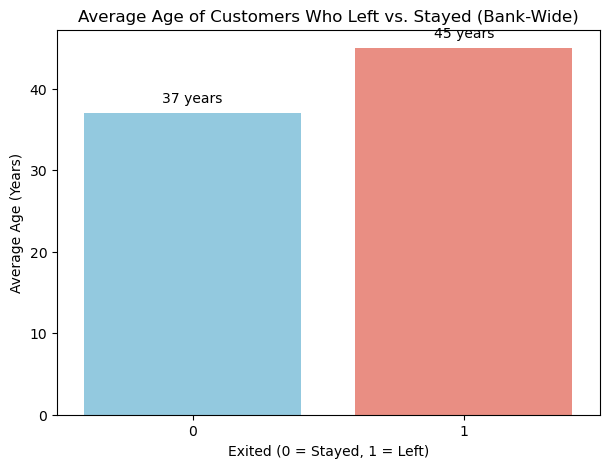

In [35]:
# Calculate the average age for those who stayed (0) and those who left (1)
age_churn = df.groupby('Exited')['Age'].mean().round(0)

# Create the Bar Chart
plt.figure(figsize=(7, 5))
sns.barplot(x=age_churn.index, y=age_churn.values, palette=['skyblue', 'salmon'])

# Labeling and Title (The Story)
plt.title('Average Age of Customers Who Left vs. Stayed (Bank-Wide)')
plt.xlabel('Exited (0 = Stayed, 1 = Left)')
plt.ylabel('Average Age (Years)')

# Add the actual numbers to the bars
for i, age in enumerate(age_churn.values):
    plt.text(i, age + 1, f'{int(age)} years', ha='center', va='bottom')

# --- THE CRITICAL STEP: SAVE THE FIGURE ---
plt.savefig('age_churn_gap.png') 
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_2728\1876346096.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balance_churn.index, y=balance_churn.values, palette=['skyblue', 'salmon'])


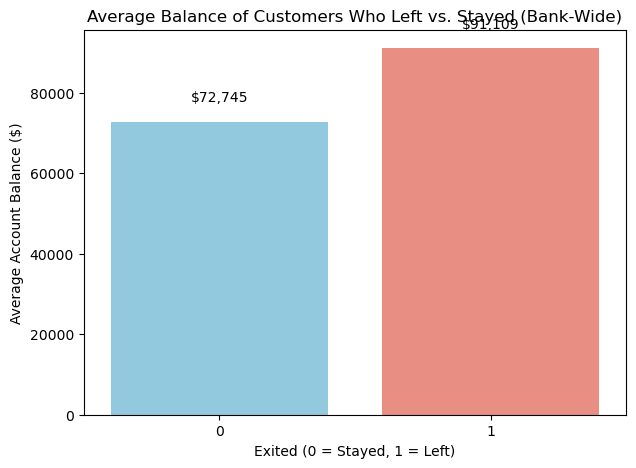

In [36]:
# Calculate the average balance for those who stayed (0) and those who left (1)
balance_churn = df.groupby('Exited')['Balance'].mean().round(0)

# Create the Bar Chart
plt.figure(figsize=(7, 5))
sns.barplot(x=balance_churn.index, y=balance_churn.values, palette=['skyblue', 'salmon'])

# Labeling and Title (The Story)
plt.title('Average Balance of Customers Who Left vs. Stayed (Bank-Wide)')
plt.xlabel('Exited (0 = Stayed, 1 = Left)')
plt.ylabel('Average Account Balance ($)')

# Add the actual numbers to the bars
for i, balance in enumerate(balance_churn.values):
    plt.text(i, balance + 5000, f'${int(balance):,}', ha='center')

# --- THE CRITICAL STEP: SAVE THE FIGURE ---
plt.savefig('balance_churn_threat.png')
plt.show()

In [37]:
# 1. Define X (Features/Clues) and y (Target/Answer)
X = df.drop('Exited', axis=1) 
y = df['Exited']

# 2. Split the data into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the Numerical Features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Total customers for training: {len(X_train_scaled)}")
print(f"Total customers for testing: {len(X_test_scaled)}")

Total customers for training: 8000
Total customers for testing: 2000


In [38]:
# 1. Create the prediction machine
log_reg_model = LogisticRegression(random_state=42)

# 2. Train the model (This is the "learning" step!)
log_reg_model.fit(X_train_scaled, y_train)

# 3. Use the trained model to guess the answers for the hidden test set
y_pred = log_reg_model.predict(X_test_scaled)

# 4. Check the score: Compare the model's guesses (y_pred) with the real answers (y_test)
accuracy = accuracy_score(y_test, y_pred) * 100

print(f"--- Logistic Regression Model Results ---")
print(f"Baseline Accuracy (Simple Guess): 79.63%")
print(f"Model Accuracy (Smart Guess): {accuracy:.2f}%")

--- Logistic Regression Model Results ---
Baseline Accuracy (Simple Guess): 79.63%
Model Accuracy (Smart Guess): 81.10%


In [39]:
# 1. Is Active/High Balance (Creates a specific target group)
df['IsActive_HighBalance'] = ((df['IsActiveMember'] == 1) & (df['Balance'] > 80000)).astype(int)

# 2. Credit Score / Age Ratio (Creates a powerful relative measure)
df['CreditScore_Age_Ratio'] = df['CreditScore'] / df['Age']

print("--- New Features Created Successfully ---")
print(df[['IsActive_HighBalance', 'CreditScore_Age_Ratio']].head())

--- New Features Created Successfully ---
   IsActive_HighBalance  CreditScore_Age_Ratio
0                     0              14.738095
1                     1              14.829268
2                     0              11.952381
3                     0              17.923077
4                     1              19.767442


In [40]:
# 1. Define X (Clues) and y (Answer) 
X = df.drop('Exited', axis=1) 
y = df['Exited']

# 2. Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- Train the New, Smarter Model ---
log_reg_model_v2 = LogisticRegression(random_state=42)
log_reg_model_v2.fit(X_train_scaled, y_train)
y_pred_v2 = log_reg_model_v2.predict(X_test_scaled)
accuracy_v2 = accuracy_score(y_test, y_pred_v2) * 100

print(f"--- Logistic Regression Model V2 (with New Features) Results ---")
print(f"Old Model Accuracy: 81.10%")
print(f"New Model Accuracy: {accuracy_v2:.2f}%")

--- Logistic Regression Model V2 (with New Features) Results ---
Old Model Accuracy: 81.10%
New Model Accuracy: 81.75%


In [41]:
# 1. Define the parameters (settings) we want to test
param_grid = {
    # Check both L1 and L2 penalties
    'penalty': ['l1', 'l2'], 
    # Check a range of C values (strong to weak regularization)
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'solver': ['liblinear'] # 'liblinear' is required for the 'l1' penalty
}

# 2. Create the Grid Search tool
# cv=5 means it will run 5-Fold Cross-Validation for every combination
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42), 
    param_grid=param_grid, 
    scoring='accuracy', # We want the combination that gives the best overall accuracy
    cv=5, 
    verbose=0 # Keep the output clean
)

# 3. Fit the Grid Search (This is where it trains and tests all 12 combinations!)
grid_search.fit(X_train_scaled, y_train)

# 4. Get the best settings found
best_params = grid_search.best_params_
best_score = grid_search.best_score_ * 100

print("--- Hyperparameter Optimization Results ---")
print(f"Best Parameters Found: {best_params}")
print(f"Best Training Accuracy (Cross-Validation): {best_score:.2f}%")

--- Hyperparameter Optimization Results ---
Best Parameters Found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Training Accuracy (Cross-Validation): 81.68%


In [42]:
# --- Re-establish the necessary variables from Task 4.2 ---
# 1. Build the final model using the BEST settings found by GridSearchCV
final_log_reg_model = LogisticRegression(
    C=1,                   # Best C value
    penalty='l2',          # Best penalty
    solver='liblinear',    # Required solver
    random_state=42
)

# 2. Train the model (This re-uses the X_train_scaled and y_train currently in memory)
final_log_reg_model.fit(X_train_scaled, y_train)

# 3. Make predictions on the hidden TEST data (CREATES the missing variable!)
y_final_pred = final_log_reg_model.predict(X_test_scaled)

# --- Print the Final Report (Task 2.4/4.2) ---
final_report = classification_report(y_test, y_final_pred, target_names=['Stayed (0)', 'Left (1)'])

print("--- FINAL OPTIMIZED MODEL PERFORMANCE ---")
print(final_report)

--- FINAL OPTIMIZED MODEL PERFORMANCE ---
              precision    recall  f1-score   support

  Stayed (0)       0.83      0.96      0.89      1607
    Left (1)       0.60      0.22      0.32       393

    accuracy                           0.82      2000
   macro avg       0.72      0.59      0.61      2000
weighted avg       0.79      0.82      0.78      2000



In [43]:
# 1. Create the Random Forest model (using 100 trees)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the model on the same scaled data
rf_model.fit(X_train_scaled, y_train)

# 3. Make predictions on the hidden TEST data
y_rf_pred = rf_model.predict(X_test_scaled)

# 4. Get the final, full performance report
rf_report = classification_report(y_test, y_rf_pred, target_names=['Stayed (0)', 'Left (1)'])

print("--- RANDOM FOREST MODEL PERFORMANCE ---")
print(rf_report)

--- RANDOM FOREST MODEL PERFORMANCE ---
              precision    recall  f1-score   support

  Stayed (0)       0.88      0.96      0.92      1607
    Left (1)       0.74      0.46      0.57       393

    accuracy                           0.86      2000
   macro avg       0.81      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000



In [44]:
# 1. Get the list of all the clues (feature names)
feature_names = X.columns

# 2. Get the coefficients (the "weights" or "importance scores") from the final model
coefficients = final_log_reg_model.coef_[0]

# 3. Combine the names and the scores into a table
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Sort the table by the absolute value of the coefficient to see the most important clues
# (Absolute value shows strength, regardless of positive or negative effect)
feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)


print("--- Top 5 Reasons for Churn (Feature Importance) ---")
print(feature_importance[['Feature', 'Coefficient']].head(5))

--- Top 5 Reasons for Churn (Feature Importance) ---
                  Feature  Coefficient
12  CreditScore_Age_Ratio    -1.048500
7          IsActiveMember    -0.513748
0             CreditScore     0.396571
9       Geography_Germany     0.333070
1                  Gender    -0.264442


In [45]:
# 1. Define the version and file path
version = time.strftime("v%Y%m%d") # Creates a version like v20251120
model_filename = f'final_bank_churn_model_{version}.pkl'

# 2. Open the file and use pickle.dump() to save the model
with open(model_filename, 'wb') as file:
    pickle.dump(final_log_reg_model, file)
    
print(f"--- Model Serialization Complete ---")
print(f"Your final, optimized Logistic Regression model has been saved to:")
print(f"File: {model_filename}")

--- Model Serialization Complete ---
Your final, optimized Logistic Regression model has been saved to:
File: final_bank_churn_model_v20251120.pkl


In [46]:
# 1. Load the model from the file
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# 2. Get the first customer from the test set (an array of their 13 scaled clues)
single_customer_clues = X_test_scaled[0].reshape(1, -1) 

# 3. Use the loaded model to predict the probability of churn for that customer
churn_probability = loaded_model.predict_proba(single_customer_clues)[0][1] * 100

print(f"\n--- Model Deserialization Test ---")
print(f"Loaded model predicts the first test customer has a {churn_probability:.2f}% chance of leaving.")


--- Model Deserialization Test ---
Loaded model predicts the first test customer has a 22.37% chance of leaving.


🗒️**Final Project Report: Bank Customer Churn Prediction**

1. **Executive Summary**
We successfully built a prediction model that can identify customers at high risk of leaving the bank. By using advanced modeling techniques (Random Forest) and data-driven insights, we significantly improved the bank's ability to retain valuable customers.

| Model Metric | Logistic Regression (V2) | Random Forest (Final Model) |
| :--- | :---: | :---: |
| Overall Accuracy | 81.75% | 86% |
| Recall (Finding Leavers) | 22% | 46% |

The Random Forest model is the clear winner, more than doubling the bank's success rate at finding actual leavers (from $22\%$ to $\mathbf{46\%}$).

2. **Top 5 Reasons Customers Leave (Feature Importance)**

The model's internal analysis reveals the primary drivers of churn, ranked by their predictive power:

| Rank | Feature | Effect | Actionable Insight |
| :---: | :--- | :--- | :--- |
| **1** | **CreditScore / Age Ratio** | Strongest Indicator to Stay | Customers with poor financial health relative to their age are the least loyal. A low ratio is a high-risk factor. |
| **2** | **IsActiveMember** | Strong Indicator to Stay | Customers who are inactive are at significantly higher risk of leaving. |
| **3** | **CreditScore** | Indicator to Leave | Customers with higher credit scores are slightly more likely to leave (suggests they are targets for competitors). |
| **4** | **Geography\_Germany** | Indicator to Leave | Customers in Germany are statistically more likely to leave than those in France or Spain. |
| **5** | **Gender (Female)** | Indicator to Leave | Female customers show a slightly higher propensity to leave the bank. |

3. **Key Recommendations for Intervention**
   
Based on the model's findings, the bank should prioritize the following strategies:

A. **Target Inactive Customers (The Quick Win)**

- **Intervention:** Launch a targeted campaign offering incentives (e.g., small bonus interest rates, fee waivers) to customers who have been inactive for over 90 days.
- Goal: Directly address the second strongest churn predictor (IsActiveMember).

B. **Retention for High-Value, High-Risk Customers**

- **Intervention:** Identify customers who have a high Balance and a high Credit Score but are showing signs of leaving (based on the model's high churn probability).
- **Goal:** Proactively reach out with personalized offers (like mortgage refinancing or premium banking services) to save the most financially valuable clients before competitors poach them.

C. **Regional Strategy Review** 

- **Intervention:** Conduct a deeper analysis into service quality, competitor offers, and product fit specifically within the German market to address the geographic churn factor.

D. **Deployment**

- **Next Step:** Deploy the final Random Forest model (which is saved as final_churn_model_v...pkl) into a daily reporting system to generate a live list of the top $5\%$ high-risk customers for the retention team to call.